In [1]:
import pandas as pd
import os
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy

In [2]:
path = os.getcwd()
dataset = 'bodyfat.csv'
path = os.getcwd() + '\\' + dataset

df = pd.read_csv(path)
df.head()

,Density,BodyFat,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
0,1.0708,12.3,23,154.25,67.75,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1
1,1.0853,6.1,22,173.25,72.25,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2
2,1.0414,25.3,22,154.00,66.25,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6
3,1.0751,10.4,26,184.75,72.25,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2
4,1.0340,28.7,24,184.25,71.25,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7


#https://www.kaggle.com/fedesoriano/body-fat-prediction-dataset

The percentage of body fat for an individual can be estimated once body density has been determined. Folks (e.g. Siri (1956)) assume that the body consists
of two components - lean body tissue and fat tissue. Letting:

D = Body Density (gm/cm^3) - This is measured - hydrostatic weighing


A = proportion of lean body tissue 
B = proportion of fat tissue (A+B=1)


a = density of lean body tissue (gm/cm^3) 
b = density of fat tissue (gm/cm^3) - fat floats in water so (Wa - Ww) = lean body mass

a and b have average value:

Using the estimates 

a=1.10 gm/cm^3 and
b=0.90 gm/cm^3 
(see Katch and McArdle (1977), p. 111 or Wilmore (1976), p. 123) we come up with "Siri's equation":


we have:

D = 1/[(A/a) + (B/b)]

solving for B we find:

B = (1/D)*[ab/(a-b)] - [b/(a-b)].

Percentage of Body Fat (i.e. 100*B)

100*B = 495/D - 450


Density from hydrostatic weighing.

Body Density;

D = WA/[(WA-WW)/c.f. - LV]

WA = Weight in air (kg)
WW = Weight in water (kg)

c.f. = Water correction factor (=1 at 39.2 deg F as one-gram of water occupies exactly one cm^3 at this temperature, =.997 at 76-78 deg F)

c.f. is really the density of water at test temperature

(WA-WW)/c.f. is the volume of water displaced by submerged body
Archemedies Principle

LV = Residual Lung Volume (liters)

Have to assume LV was accounted for appropiately

B = (1/D)*[ab/(a-b)] - [b/(a-b)]

In [3]:
def BodyFatP(D, a = 1.1, b = .9):
    """returns percentage of body fat as estimated by siri equation"""
    B = 100*((1/D)*(a*b)/(a-b) - b/(a-b))
    return B

def calc_BMI(H, W):
    """Calculate BMI from Height (inches) and Weight (lbs)"""
    BMI = 703*W/H**2
    return BMI



In [4]:
min_d = min(df['Density'])
max_d = max(df['Density'])

print('Minimum density in dataset = ', str(min_d))
print('the lower bound seems reasonable wrt the Siri equation Coefficient\n')

print('Maximum density in dataset = ', str(max_d))
print('however the upper bound is suspicious because an entire body density is about the average of lean tissue\n')

bodyfat_max_d = BodyFatP(max_d)

print('body fat percentage corresponding to max density in dataset = ', str(bodyfat_max_d))
print('which is clearly nonsensical')

Minimum density in dataset =  0.995
the lower bound seems reasonable wrt the Siri equation Coefficient

Maximum density in dataset =  1.1089
however the upper bound is suspicious because an entire body density is about the average of lean tissue

body fat percentage corresponding to max density in dataset =  -3.611687257642604
which is clearly nonsensical


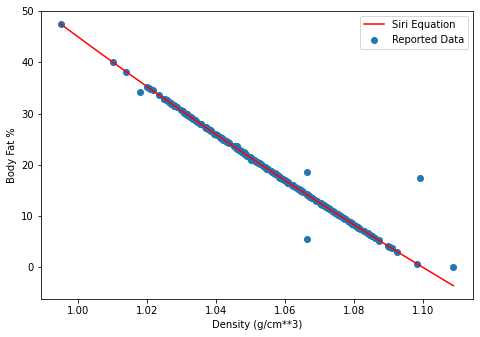

In [5]:
DensityBounds = np.linspace(min(df['Density']), max(df['Density']), 25)
SiriBP = [BodyFatP(i) for i in DensityBounds]

fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(df['Density'],df['BodyFat'])
ax.plot(DensityBounds,SiriBP,'r')

ax.set_xlabel('Density (g/cm**3)')
ax.set_ylabel('Body Fat %')
ax.legend(['Siri Equation', 'Reported Data'])
plt.show()

In [7]:
#finding the data that is off of the siri equation line
DensityPoints = df['Density']
BodyFatP_Points = df['BodyFat']

SiriBP_D = [BodyFatP(i) for i in DensityPoints]

df_Sc = df[['Density', 'BodyFat']]
df_Sc.insert(loc=2, column='BodyFatCalc',value=SiriBP_D)
series1 = df_Sc['BodyFat'] - df_Sc['BodyFatCalc']
df_Sc = df_Sc[abs(series1)>.5]

df_Sc



,Density,BodyFat,BodyFatCalc
47,1.0665,5.6,14.135021
75,1.0666,18.5,14.091506
95,1.0991,17.4,0.368483
168,1.0180,34.3,36.247544
181,1.1089,0.0,-3.611687


Visual confirmation that data was removed successfully


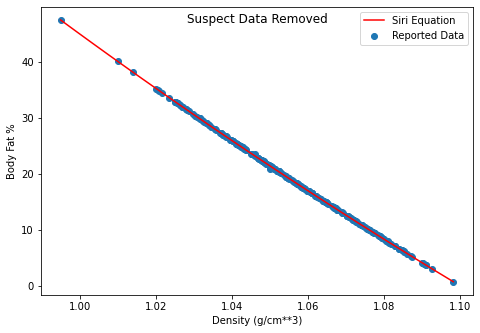

In [8]:
#df_clean has removed the 5 points found above

df_clean = df[abs(series1)<.5]


print('Visual confirmation that data was removed successfully')
DensityBounds = np.linspace(min(df_clean['Density']), max(df_clean['Density']), 25)
SiriBP = [BodyFatP(i) for i in DensityBounds]

fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(df_clean['Density'],df_clean['BodyFat'])
ax.plot(DensityBounds,SiriBP,'r')

ax.set_xlabel('Density (g/cm**3)')
ax.set_ylabel('Body Fat %')
ax.legend(['Siri Equation', 'Reported Data'])
fig.suptitle('Suspect Data Removed', fontsize=12)
plt.show()

In [9]:
#Inserting a BMI Feature
df_clean.insert(loc=2, column='BMI',value=calc_BMI(df_clean['Height'],df_clean['Weight']))
df_clean.head()

,Density,BodyFat,BMI,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
0,1.0708,12.3,23.624460,23,154.25,67.75,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1
1,1.0853,6.1,23.332048,22,173.25,72.25,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2
2,1.0414,25.3,24.666315,22,154.00,66.25,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6
3,1.0751,10.4,24.880784,26,184.75,72.25,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2
4,1.0340,28.7,25.514854,24,184.25,71.25,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7


In [10]:
#Using the BMI feature to count Obesity in the data and for outlier checks
print('min BMI in data ' + str(min(df_clean['BMI'])))
print('max BMI in data ' + str(max(df_clean['BMI'])))

df_cleaner = df_clean[df_clean['BMI']<100] #remove the outlying data

num_of_obese = len(df_cleaner[df_cleaner['BMI']>30])

print('\n')
print('the number of obese men in this dataset is ' + str(num_of_obese))


BMI_df = df_clean[df_clean['BMI']>30].sort_values(['BMI'],ascending=False)

BMI_df.iloc[:,:3].reset_index(0)

min BMI in data 19.042117214532873
max BMI in data 165.60183855214018


the number of obese men in this dataset is 23


,index,Density,BodyFat,BMI
0,41,1.0250,32.9,165.601839
1,38,1.0202,35.2,48.906397
2,40,1.0217,34.5,39.079828
3,215,0.9950,47.5,37.587158
4,241,1.0207,35.0,33.881791
5,177,1.0316,29.9,33.174972
6,204,1.0209,34.8,32.223430
7,34,1.0263,32.3,32.174881
8,35,1.0101,40.1,31.905385
9,237,1.0372,27.3,31.895337


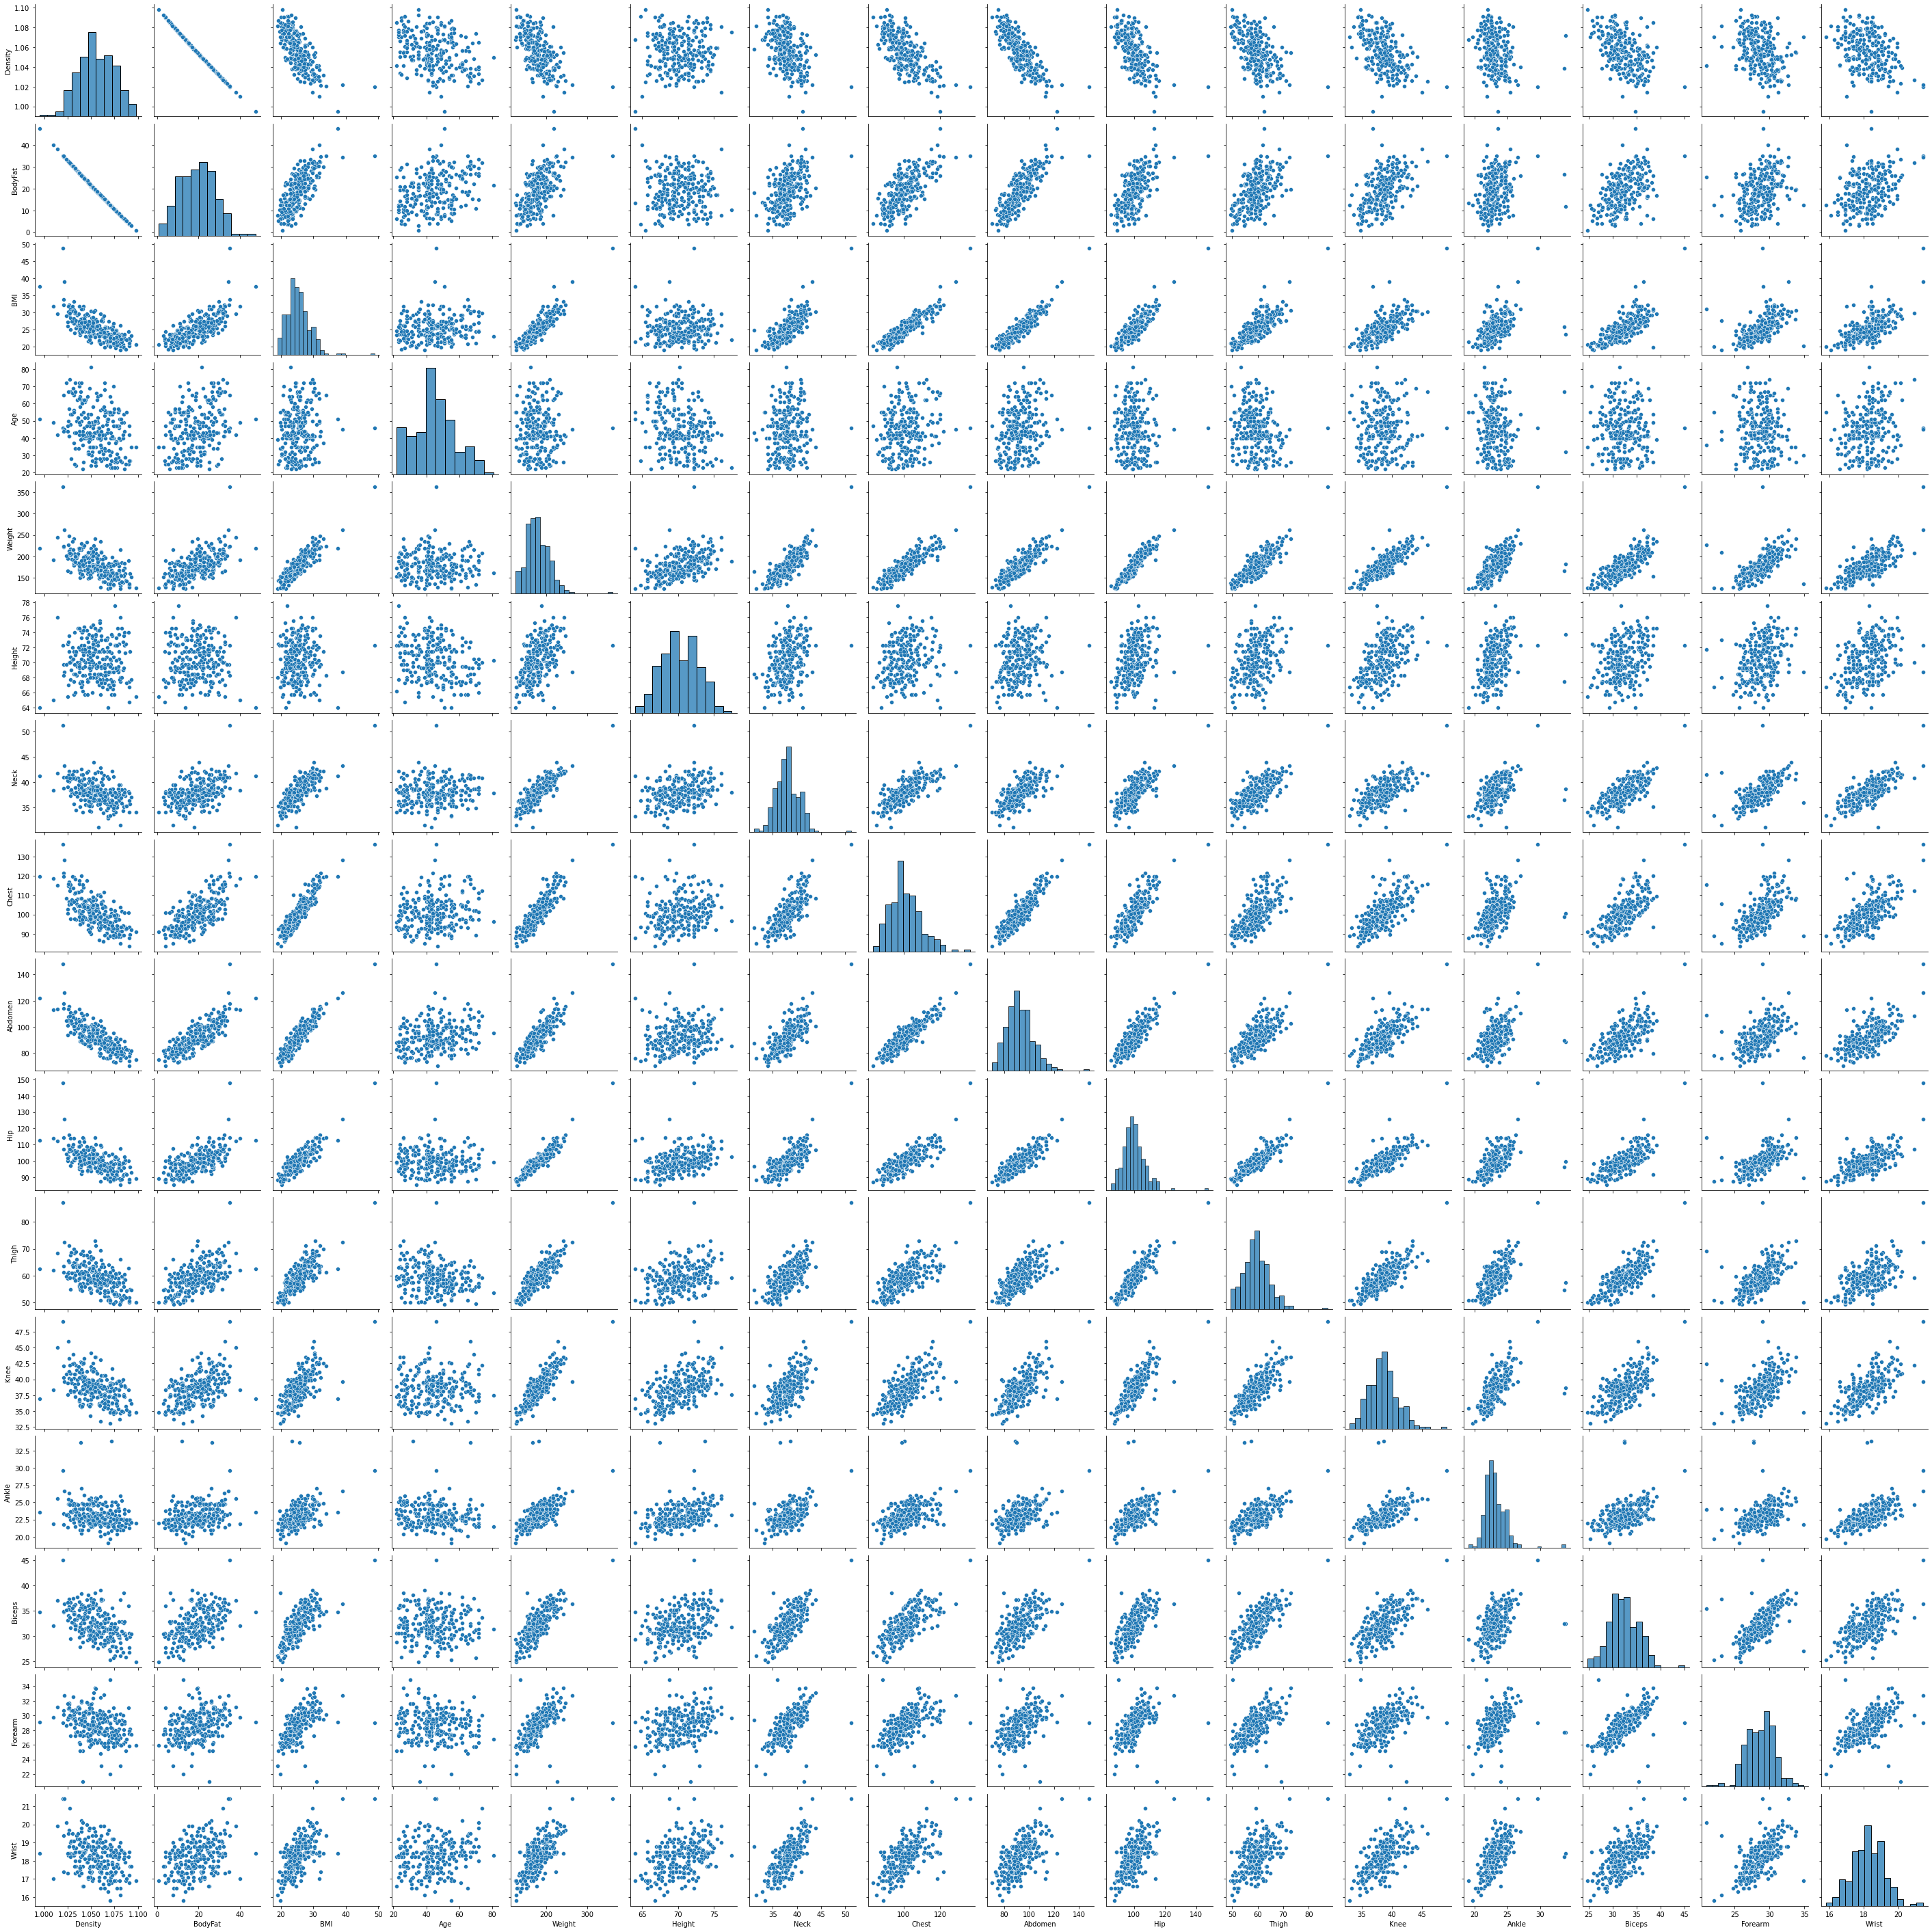

In [11]:
#next will be to construct a pairplot to examine feature association
sns.pairplot(df_cleaner)

In [12]:
#prime variables for hypothesis testing 
a = df_cleaner['Height']            
b =df_cleaner['BodyFat']
c = df_cleaner['Ankle']
d = df_cleaner['Age']
e = df_cleaner['BMI']
w = df_cleaner['Weight']

In [13]:
#this fxn does a Significance of the Correlation Coefficient test
#Ho: rho = 0.  No correlation
#Ha: rho != 0.  Correlated
#alpha = .05.  
#since p > alpha Do not reject null 
statlist = list(stats.linregress(a,b))

p = statlist[-2]

print(' p = ' + str(p))

print('\n p > 0.05. \n Do not reject the null.  \n Pragmatically, Height and BodyFat percentages are not correlated in this dataset')



 p = 0.6852801505248841

 p > 0.05. 
 Do not reject the null.  
 Pragmatically, Height and BodyFat percentages are not correlated in this dataset


In [14]:
statlist =  stats.linregress(b,c)
p = statlist[-2]

print(' p = ' + str(p))

print('\n p < 0.05. \n Reject the null.  \n Height and Ankle size have a statistically significant correlation in this dataset')

 p = 8.04881002976529e-05

 p < 0.05. 
 Reject the null.  
 Height and Ankle size have a statistically significant correlation in this dataset


In [20]:
df_cleaner.head()

,Density,BodyFat,BMI,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
0,1.0708,12.3,23.624460,23,154.25,67.75,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1
1,1.0853,6.1,23.332048,22,173.25,72.25,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2
2,1.0414,25.3,24.666315,22,154.00,66.25,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6
3,1.0751,10.4,24.880784,26,184.75,72.25,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2
4,1.0340,28.7,25.514854,24,184.25,71.25,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7


In [15]:
#Below this is initial EDA - Not used formally 

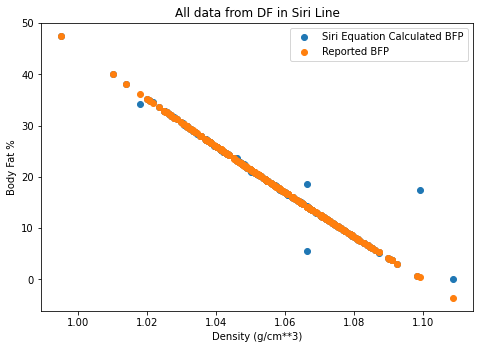

In [16]:
DensityPoints = df['Density']
BodyFatP_Points = df['BodyFat']

SiriBP_D = [BodyFatP(i) for i in DensityPoints]

fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(DensityPoints,BodyFatP_Points)
ax.scatter(DensityPoints,SiriBP_D)#,'r-')

ax.set_xlabel('Density (g/cm**3)')
ax.set_ylabel('Body Fat %')
ax.legend(['Siri Equation Calculated BFP', 'Reported BFP'])
plt.title('All data from DF in Siri Line')
plt.show()

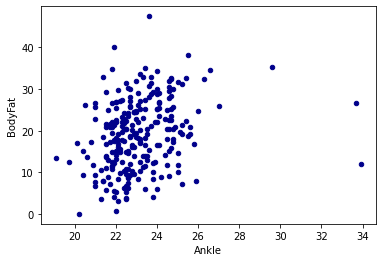

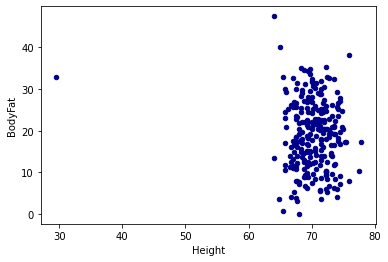

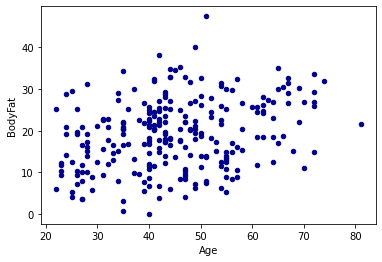

In [17]:

df.plot.scatter(x='Ankle',
                      y='BodyFat',
                      c='DarkBlue')

ax1 = df.plot.scatter(x='Height',
                      y='BodyFat',
                      c='DarkBlue')

ax1 = df.plot.scatter(x='Age',
                      y='BodyFat',
                      c='DarkBlue')

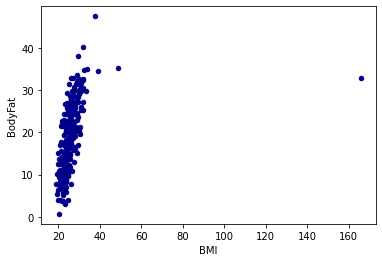

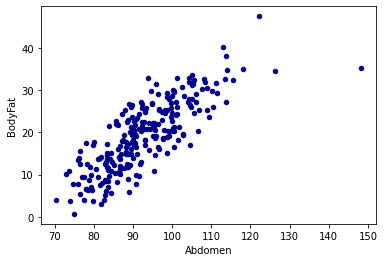

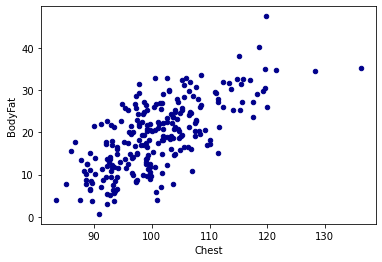

In [18]:

df_clean.plot.scatter(x='BMI',
                      y='BodyFat',
                      c='DarkBlue')

ax1 = df_clean.plot.scatter(x='Abdomen',
                      y='BodyFat',
                      c='DarkBlue')

ax1 = df_clean.plot.scatter(x='Chest',
                      y='BodyFat',
                      c='DarkBlue')

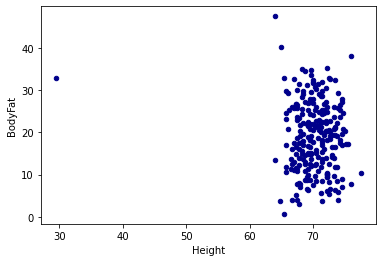

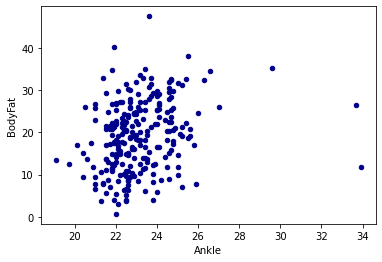

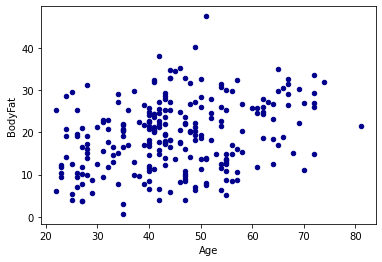

In [19]:

df_clean.plot.scatter(x='Height',
                      y='BodyFat',
                      c='DarkBlue')

ax1 = df_clean.plot.scatter(x='Ankle',
                      y='BodyFat',
                      c='DarkBlue')

ax1 = df_clean.plot.scatter(x='Age',
                      y='BodyFat',
                      c='DarkBlue')